**Sawyer Strong & Erik Cohen**

Fall 2019

CS343 Neural Networks

Project 4: Transfer Learning and Deep Dream

EXTENSION FILE: 

In this files, we display the working of our adversarial attack. To do this, we first train a mnist categorizer on the 60k data set which manages to achieve a 98.24% test accuracy. We then try to make little changes to one of the input images so as to have the program miscalcategorize the image. This is done in a similar way as Deep Dream is done. In this case however, we find the loss for the correct classification of the image and then apply back propagation of that back down to the image. Doing this, gives us the weights that when reduced would give reinforce the prediction of the image. Thus, to make the image only look slightly different but still impact the classification, instead of reducing this, we increase this value. We keep doing this until the model misclassifies the value. By doing this, we can create images that to the human eye would be considered part of one category but the model would classify as a different category. This way, we can use adversarial attacks to make a neural net fail. This can be used to improve the training of the model, by supplementing the training set by making small visually insignificant changes to the data and having the model train on these. However, these neeed to be monitored as they are weakly labelled and we might end up training the model on an image that may infact be another number.

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.datasets import mnist
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

print(tf.__version__)

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


2.0.0


In [2]:
batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                             activation='relu',
                             input_shape=input_shape),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("X_train shape: ",x_train.shape)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 53s 883us/sample - loss: 0.2512 - accuracy: 0.9232 - val_loss: 0.0590 - val_accuracy: 0.9824
Test loss: 0.05901431376256514
Test accuracy: 0.9824
X_train shape:  (60000, 28, 28, 1)


In [7]:
test_image = x_train[0]
test_label = y_train[0]

test_image = np.reshape(test_image, (1,28,28,1))
print("prediction:", model(test_image).numpy().argmax())

prediction: 5


In [25]:
def plot_weights(wts, saveFig=True, labels=None, filename='convWts_adam_overfit.png'):
    grid_sz = int(np.sqrt(len(wts)))
    plt.figure(figsize=(10,10))
    for x in range(grid_sz):
        for y in range(grid_sz):
            lin_ind = np.ravel_multi_index((x, y), dims=(grid_sz, grid_sz))
            plt.subplot(grid_sz, grid_sz, lin_ind+1)
            currImg = wts[lin_ind]
            low, high = np.min(currImg), np.max(currImg)
            currImg = 255*(currImg - low) / (high - low)
            currImg = currImg.astype('uint8')
            if labels is not None:
                plt.title(labels[y][x])
            plt.imshow(currImg)
            plt.gca().axis('off')
    if saveFig:
        plt.savefig('convWts_adam_overfit.png')
    plt.show()

In [55]:
from deep_dream import *

In [58]:
nm = Nightmare(model)

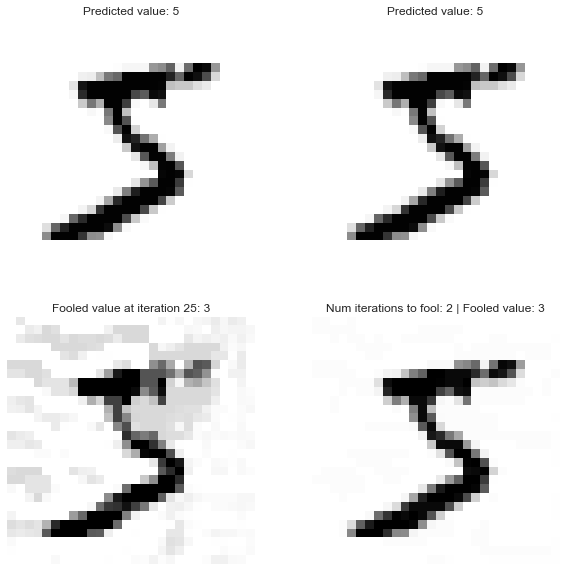

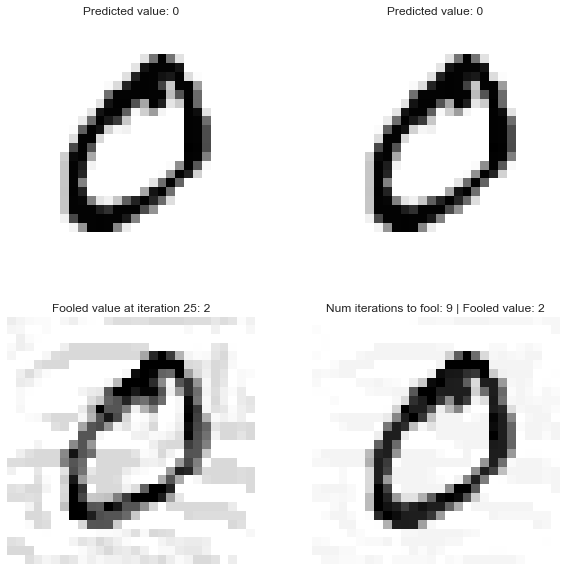

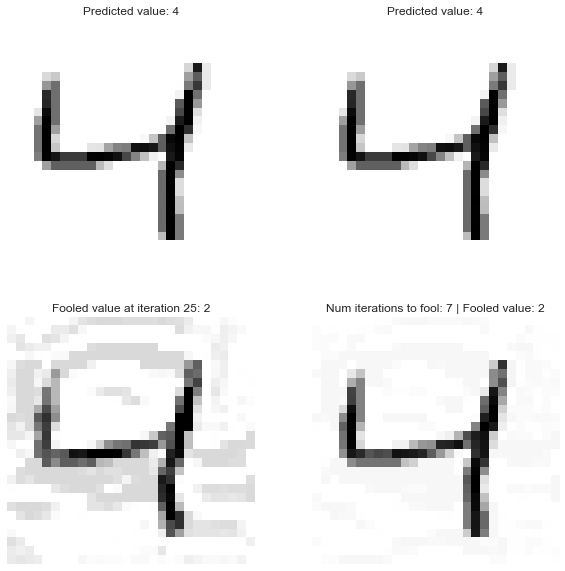

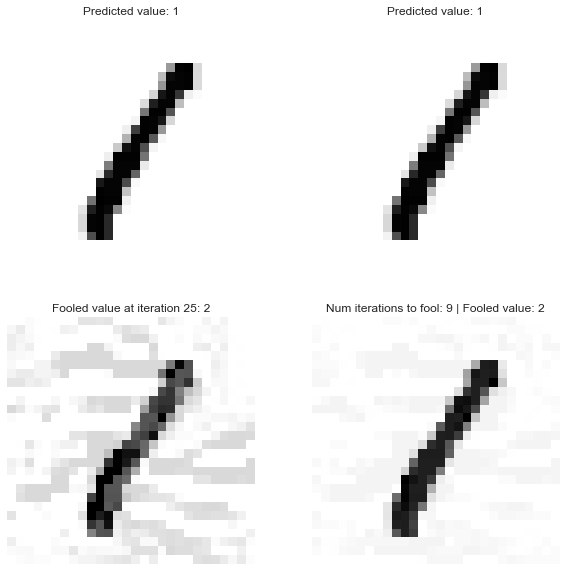

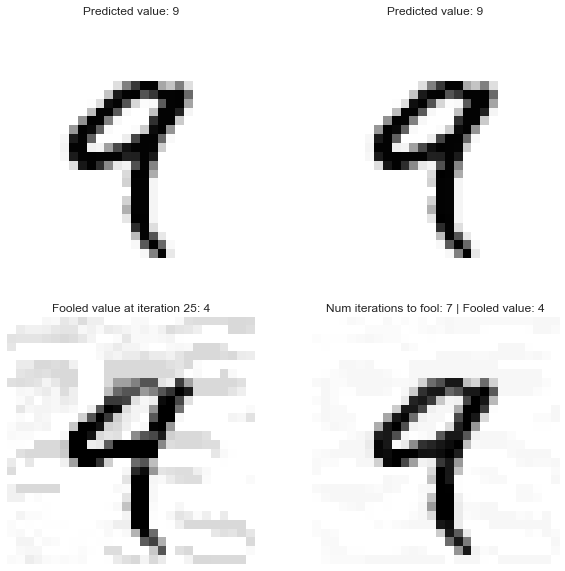

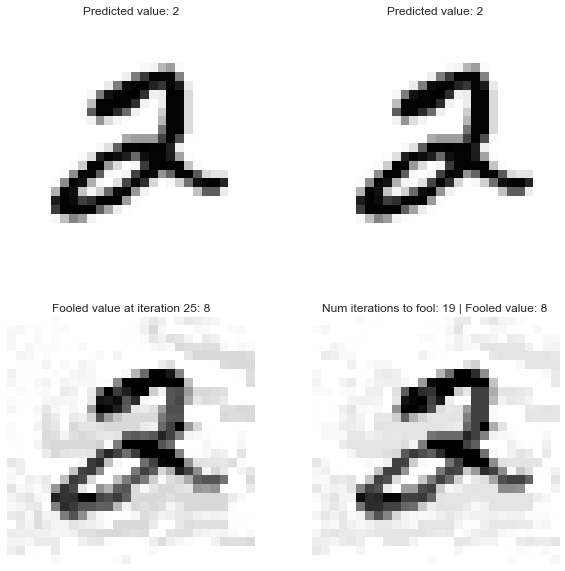

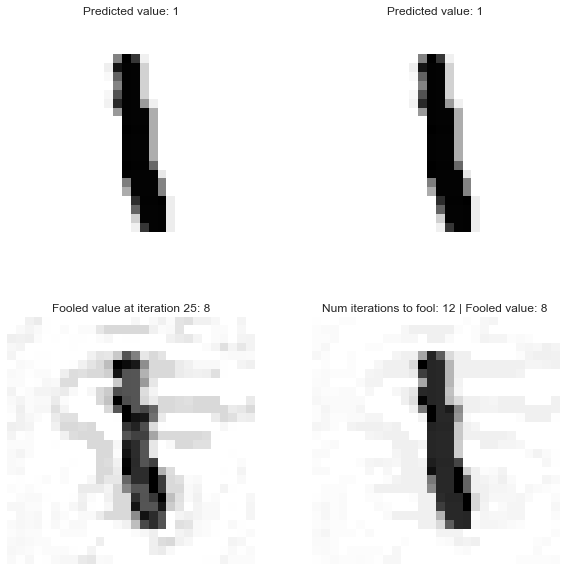

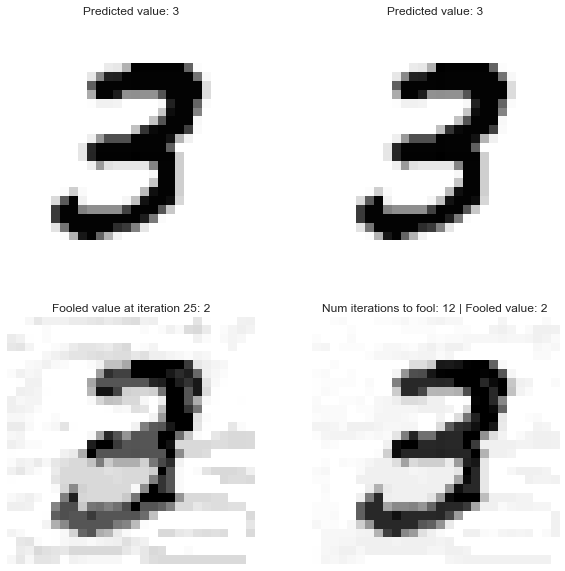

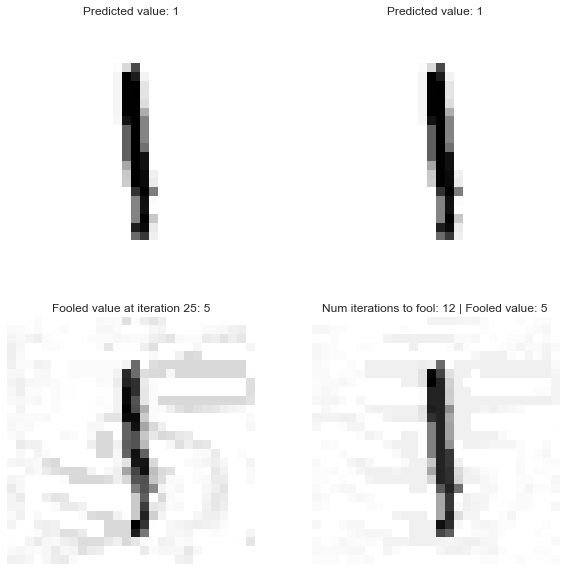

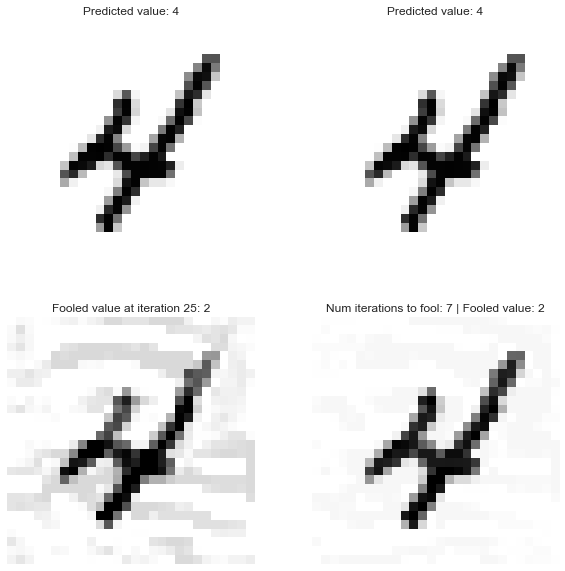

In [71]:
test_imgs = x_train[0:10]
test_labels = y_train[0:10]

for img, label in zip(test_imgs, test_labels):
    tf_img = tf.Variable(img)
    tf_img = tf.expand_dims(tf_img, axis=0)
    fooled = nm.wrong(tf_img, label, 25)
    count, min_fooled = nm.minimal_wrong(tf_img, label)
    pred_val = model(tf_img).numpy().argmax()
    fool_val = model(fooled).numpy().argmax()
    min_fool_val = model(min_fooled).numpy().argmax()

    img1 = nm.tf2array((tf_img)[0,:,:,0])
    img2 = nm.tf2array((fooled)[0,:,:,0])
    img3 = nm.tf2array((min_fooled)[0,:,:,0])
    plot_weights([img1, img1, img2, img3], labels=[["Predicted value: "+str(pred_val), "Fooled value at iteration 25: "+str(fool_val)],["Predicted value: "+str(pred_val), "Num iterations to fool: "+ str(count) +" | Fooled value: "+str(min_fool_val)]])